In [1]:
#Import
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from lifelines.utils import concordance_index

In [2]:
# choose random seeds
np.random.seed(0)
seeds = np.random.permutation(1000)[:25]

In [3]:
#Import Dataset
df_raw = sm.datasets.get_rdataset('pbc', 'survival').data
df_no_nans = df_raw.dropna()   #no nan values
df_no_nans = df_no_nans.drop('id', axis=1)  #first innecesary column
df_trans = df_no_nans['status']   #to use this variable dont run next square

In [4]:
# Only status 2 is an event
df_no_nans['status']=df_no_nans['status'].replace(1,False)      
df_no_nans['status']=df_no_nans['status'].replace(2,True) 
df_no_nans['status']=df_no_nans['status'].replace(0,False)
df_no_nans.head(8)

,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
0,400,1,1.0,58.765229,f,1.0,1.0,1.0,1.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,0,1.0,56.446270,f,0.0,1.0,1.0,0.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,1,1.0,70.072553,m,0.0,0.0,0.0,0.5,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,1,1.0,54.740589,f,0.0,1.0,1.0,0.5,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,0,2.0,38.105407,f,0.0,1.0,1.0,0.0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
6,1832,0,2.0,55.534565,f,0.0,1.0,0.0,0.0,1.0,322.0,4.09,52.0,824.0,60.45,213.0,204.0,9.7,3.0
7,2466,1,2.0,53.056810,f,0.0,0.0,0.0,0.0,0.3,280.0,4.00,52.0,4651.2,28.38,189.0,373.0,11.0,3.0
8,2400,1,1.0,42.507871,f,0.0,0.0,1.0,0.0,3.2,562.0,3.08,79.0,2276.0,144.15,88.0,251.0,11.0,2.0


In [5]:
#Identify X and y
from sksurv.datasets import get_x_y

X, y = get_x_y(df_no_nans, attr_labels=['status','time'], pos_label=True)

In [6]:
# number of samples, number of features/covariables
print(f'samples: {X.shape[0]}')
print(f'features/covariables: {X.shape[1]}\n')
print(f'right censored samples: {len(df_no_nans.query("status == False"))}')
print(f'percentage of right censored samples: {100*len(df_no_nans.query("status == False"))/len(df_no_nans):.1f}%')

samples: 276
features/covariables: 17

right censored samples: 165
percentage of right censored samples: 59.8%


In [7]:
#Split on training and validation data
from sklearn.model_selection import train_test_split

X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=42)

print(f'Number of training samples: {len(y_trn)}')
print(f'Number of validation samples: {len(y_val)}')

Number of training samples: 207
Number of validation samples: 69


In [8]:
#Set the scaling columns
scaling_cols=['age','bili','chol','albumin','copper','alk.phos','ast','trig','platelet','protime']
scaling_cols

['age',
 'bili',
 'chol',
 'albumin',
 'copper',
 'alk.phos',
 'ast',
 'trig',
 'platelet',
 'protime']

In [9]:
#Set categorical columns
cat_cols=['trt','edema','sex','ascites','hepato','spiders','stage']
cat_cols

['trt', 'edema', 'sex', 'ascites', 'hepato', 'spiders', 'stage']

In [10]:
#Preprocessor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    [('cat-preprocessor', OrdinalEncoder(), cat_cols),
    ('standard-scaler', StandardScaler(), scaling_cols)],
    remainder='passthrough', sparse_threshold=0)

## **Cox Proportional Hazards**

In [11]:
#Cox model for the original split
from sklearn.pipeline import make_pipeline
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored


cox = make_pipeline(preprocessor, CoxPHSurvivalAnalysis())
cox.fit(X_trn, y_trn)

ci_cox = concordance_index_censored(y_val["status"], y_val["time"], cox.predict(X_val))
print(f'The c-index of Cox is given by {ci_cox[0]:.3f}')

The c-index of Cox is given by 0.870


In [12]:
#Cox model for each different split
cox_scores = []
for _seed in seeds:
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=_seed)
  
    cox = make_pipeline(preprocessor, CoxPHSurvivalAnalysis())
    cox.fit(X_trn, y_trn)
    cox_scores.append(cox.score(X_val, y_val))

In [13]:
#Save results in a csv 
df_cox_scores = pd.DataFrame({'Seed': seeds, 'Cox PH' : cox_scores})
df_cox_scores.to_csv('scores.csv', mode='w')

## **Random Survival Forest**

In [14]:
from sklearn.pipeline import make_pipeline
from sksurv.ensemble import RandomSurvivalForest

rsf = make_pipeline(preprocessor, RandomSurvivalForest(random_state=42))

rsf.fit(X_trn, y_trn)

ci_rsf = concordance_index_censored(y_val["status"], y_val["time"], rsf.predict(X_val))
print(f'The c-index of Random Survival Forest is given by {ci_rsf[0]:.3f}')

The c-index of Random Survival Forest is given by 0.880


In [15]:
rsf_scores = []
for _seed in seeds:
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=_seed)
  
    rsf = make_pipeline(preprocessor, RandomSurvivalForest(random_state=42))
    rsf.fit(X_trn, y_trn)
    rsf_scores.append(rsf.score(X_val, y_val))

In [16]:
df_csv = pd.read_csv('scores.csv')
df_csv['RSF'] = pd.Series(rsf_scores)
df_csv.to_csv('scores.csv', mode='w')

## **Gradient Boosting**

In [17]:
from sklearn.pipeline import make_pipeline
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

gbc = make_pipeline(preprocessor, GradientBoostingSurvivalAnalysis(random_state=42))

gbc.fit(X_trn, y_trn)

ci_gbc = concordance_index_censored(y_val["status"], y_val["time"], gbc.predict(X_val))
print(f'The c-index of Gradient Boosting Cox PH is given by {ci_gbc[0]:.3f}')


The c-index of Gradient Boosting Cox PH is given by 0.866


In [18]:
gbc_scores = []
for _seed in seeds:
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=_seed)
  
    gbc = make_pipeline(preprocessor, GradientBoostingSurvivalAnalysis(random_state=42))
    gbc.fit(X_trn, y_trn)
    gbc_scores.append(gbc.score(X_val, y_val))

In [19]:
df_csv = pd.read_csv('scores.csv')
df_csv['GBC'] = pd.Series(gbc_scores)
df_csv.to_csv('scores.csv', mode='w')

## **Weibull AFT**

In [20]:
columns_encoded = X_trn.columns

X_trn1 = preprocessor.fit_transform(X_trn)
X_val1 = preprocessor.transform(X_val)

X_trn1 = pd.DataFrame(X_trn1, columns=columns_encoded)
X_val1 = pd.DataFrame(X_val1, columns=columns_encoded)

In [21]:
X_trn1['status'] = y_trn['status']
X_val1['status'] = y_val['status']

In [22]:
from lifelines.utils.sklearn_adapter import sklearn_adapter
from lifelines import WeibullAFTFitter

WeibullAFTRegression = sklearn_adapter(WeibullAFTFitter, event_col='status')
sk_aft = WeibullAFTRegression()
sk_aft.fit(X_trn1, y_trn['time'])
ci_aft = sk_aft.score(X_val1, y_val['time'])
print(f'The c-index of Weibull AFT is given by {ci_aft:.3f}')

The c-index of Weibull AFT is given by 0.860


In [23]:
aft_scores = []
for _seed in seeds:
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=_seed)
    
    X_trn1 = preprocessor.fit_transform(X_trn)
    X_val1 = preprocessor.transform(X_val)
    X_trn1 = pd.DataFrame(X_trn1, columns=columns_encoded)
    X_val1 = pd.DataFrame(X_val1, columns=columns_encoded)
    X_trn1['status'] = y_trn['status']
    X_val1['status'] = y_val['status']
  
    WeibullAFTRegression = sklearn_adapter(WeibullAFTFitter, event_col='status')
    sk_aft = WeibullAFTRegression()
    sk_aft.fit(X_trn1, y_trn['time'])
    
    aft_scores.append(sk_aft.score(X_val1, y_val['time']))

In [24]:
df_csv = pd.read_csv('scores.csv')
df_csv['AFT'] = pd.Series(aft_scores)
df_csv.to_csv('scores.csv', mode='w')

## **Aalen's Additive**

In [25]:
from lifelines import AalenAdditiveFitter

AalenAdditiveRegression = sklearn_adapter(AalenAdditiveFitter, event_col='status')
sk_aa = AalenAdditiveRegression()
sk_aa.fit(X_trn1, y_trn['time'])
ci_aa = sk_aa.score(X_val1, y_val['time'])
print(f"The c-index of Aalen's additive model is given by {ci_aa:.3f}")

The c-index of Aalen's additive model is given by 0.840


In [26]:
aa_scores = []
for _seed in seeds:
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=_seed)
    
    X_trn1 = preprocessor.fit_transform(X_trn)
    X_val1 = preprocessor.transform(X_val)
    X_trn1 = pd.DataFrame(X_trn1, columns=columns_encoded)
    X_val1 = pd.DataFrame(X_val1, columns=columns_encoded)
    X_trn1['status'] = y_trn['status']
    X_val1['status'] = y_val['status']
  
    AalenAdditiveRegression = sklearn_adapter(AalenAdditiveFitter, event_col='status')
    sk_aa = AalenAdditiveRegression()
    sk_aa.fit(X_trn1, y_trn['time'])
    
    aa_scores.append(sk_aa.score(X_val1, y_val['time']))

c:\users\cami_\miniconda3\lib\site-packages\lifelines\fitters\aalen_additive_fitter.py:239: ConvergenceWarning: Linear regression error at index=72, time=3170.000. Try increasing the coef_penalizer value.
  ConvergenceWarning,
c:\users\cami_\miniconda3\lib\site-packages\lifelines\fitters\aalen_additive_fitter.py:239: ConvergenceWarning: Linear regression error at index=73, time=3244.000. Try increasing the coef_penalizer value.
  ConvergenceWarning,
c:\users\cami_\miniconda3\lib\site-packages\lifelines\fitters\aalen_additive_fitter.py:239: ConvergenceWarning: Linear regression error at index=74, time=3282.000. Try increasing the coef_penalizer value.
  ConvergenceWarning,
c:\users\cami_\miniconda3\lib\site-packages\lifelines\fitters\aalen_additive_fitter.py:239: ConvergenceWarning: Linear regression error at index=75, time=3574.000. Try increasing the coef_penalizer value.
  ConvergenceWarning,
c:\users\cami_\miniconda3\lib\site-packages\lifelines\fitters\aalen_additive_fitter.py:239: 

c:\users\cami_\miniconda3\lib\site-packages\lifelines\fitters\aalen_additive_fitter.py:239: ConvergenceWarning: Linear regression error at index=77, time=3170.000. Try increasing the coef_penalizer value.
  ConvergenceWarning,
c:\users\cami_\miniconda3\lib\site-packages\lifelines\fitters\aalen_additive_fitter.py:239: ConvergenceWarning: Linear regression error at index=78, time=3244.000. Try increasing the coef_penalizer value.
  ConvergenceWarning,
c:\users\cami_\miniconda3\lib\site-packages\lifelines\fitters\aalen_additive_fitter.py:239: ConvergenceWarning: Linear regression error at index=79, time=3282.000. Try increasing the coef_penalizer value.
  ConvergenceWarning,
c:\users\cami_\miniconda3\lib\site-packages\lifelines\fitters\aalen_additive_fitter.py:239: ConvergenceWarning: Linear regression error at index=80, time=3395.000. Try increasing the coef_penalizer value.
  ConvergenceWarning,
c:\users\cami_\miniconda3\lib\site-packages\lifelines\fitters\aalen_additive_fitter.py:239: 

In [27]:
df_csv = pd.read_csv('scores.csv')
df_csv['Aalen'] = pd.Series(aa_scores)
df_csv.to_csv('scores.csv', mode='w')

## **Cox Randomized Search**

In [28]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'coxphsurvivalanalysis__alpha': reciprocal(0.1, 100),
}

model_random_search = RandomizedSearchCV(cox, param_distributions=param_distributions, n_iter=50, n_jobs=-1, cv=5, random_state=42)
model_random_search.fit(X_trn, y_trn)

print(
    f"The c-index of Cox using a {model_random_search.__class__.__name__} is "
    f"{model_random_search.score(X_val, y_val):.3f}")
print(
    f"The best set of parameters is: {model_random_search.best_params_}"
)

The c-index of Cox using a RandomizedSearchCV is 0.895
The best set of parameters is: {'coxphsurvivalanalysis__alpha': 31.428808908401084}


c:\users\cami_\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [29]:
alpha = model_random_search.best_params_
alpha = np.array( tuple(alpha.values()) )

In [30]:
cox_rs_scores = []
for _seed in seeds:
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=_seed)
  
    cox_rs = make_pipeline(preprocessor, CoxPHSurvivalAnalysis(alpha))
    cox_rs.fit(X_trn, y_trn)
    cox_rs_scores.append(cox_rs.score(X_val, y_val))

In [31]:
df_csv = pd.read_csv('scores.csv')
df_csv['RS Cox'] = pd.Series(cox_rs_scores)
df_csv.to_csv('scores.csv', mode='w')

## **RSF Randomized Search**

In [32]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

class reciprocal_int:
    def __init__(self, a, b):
        self._distribution = reciprocal(a, b)

    def rvs(self, *args, **kwargs):
        return self._distribution.rvs(*args, **kwargs).astype(int)

param_distributions1 = {
    'randomsurvivalforest__max_features': reciprocal_int(3, 8),
    'randomsurvivalforest__max_depth': reciprocal_int(5, 50),
    'randomsurvivalforest__min_samples_leaf': reciprocal_int(1, 40),
}

model_random_search = RandomizedSearchCV(
    rsf, param_distributions=param_distributions1, n_iter=50, n_jobs=-1, cv=5, random_state=42)
model_random_search.fit(X_trn, y_trn)

print(
    f"The c-index of random survival forest using a {model_random_search.__class__.__name__} is "
    f"{model_random_search.score(X_val, y_val):.3f}")
print(
    f"The best set of parameters is: {model_random_search.best_params_}"
)

c:\users\cami_\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The c-index of random survival forest using a RandomizedSearchCV is 0.883
The best set of parameters is: {'randomsurvivalforest__max_depth': 6, 'randomsurvivalforest__max_features': 3, 'randomsurvivalforest__min_samples_leaf': 3}


In [34]:
params = model_random_search.best_params_
params = np.array(tuple(params.values()))

In [35]:
rsf_rs_scores = []
for _seed in seeds:
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=_seed)
  
    rsf_rs = make_pipeline(preprocessor, RandomSurvivalForest(max_depth=params[0], max_features=params[1], min_samples_leaf=params[2], random_state=42))
    rsf_rs.fit(X_trn, y_trn)
    rsf_rs_scores.append(rsf_rs.score(X_val, y_val))

In [36]:
df_csv = pd.read_csv('scores.csv')
df_csv['RS RSF'] = pd.Series(rsf_rs_scores)
df_csv.to_csv('scores.csv', mode='w')

## **Gradient Boosting Randomized Search**

In [37]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

class reciprocal_int:
    def __init__(self, a, b):
        self._distribution = reciprocal(a, b)

    def rvs(self, *args, **kwargs):
        return self._distribution.rvs(*args, **kwargs).astype(int)

param_distributions2 = {
    'gradientboostingsurvivalanalysis__learning_rate': reciprocal(0.001, 1),
    'gradientboostingsurvivalanalysis__max_depth': reciprocal_int(5, 50),
    'gradientboostingsurvivalanalysis__min_samples_leaf': reciprocal_int(1, 40),
}

model_random_search = RandomizedSearchCV(gbc, param_distributions=param_distributions2, n_iter=50, n_jobs=-1, cv=5, random_state=42)
model_random_search.fit(X_trn, y_trn)

print(
    f"The c-index of gradient boosting Cox PH using a {model_random_search.__class__.__name__} is "
    f"{model_random_search.score(X_val, y_val):.3f}")
print(
    f"The best set of parameters is: {model_random_search.best_params_}"
)

The c-index of gradient boosting Cox PH using a RandomizedSearchCV is 0.860
The best set of parameters is: {'gradientboostingsurvivalanalysis__learning_rate': 0.07947147424653742, 'gradientboostingsurvivalanalysis__max_depth': 37, 'gradientboostingsurvivalanalysis__min_samples_leaf': 19}


c:\users\cami_\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [38]:
gb_params = model_random_search.best_params_
gb_params = np.array(tuple(gb_params.values()))

In [39]:
gbc_rs_scores = []
for _seed in seeds:
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=_seed)
  
    gbc_rs = make_pipeline(preprocessor, GradientBoostingSurvivalAnalysis(learning_rate= gb_params[0], \
                                                                         max_depth= gb_params[1], min_samples_leaf= gb_params[2], \
                                                                         random_state=42))
    gbc_rs.fit(X_trn, y_trn)
    gbc_rs_scores.append(gbc_rs.score(X_val, y_val))

In [40]:
df_csv = pd.read_csv('scores.csv')
df_csv['RS GBC'] = pd.Series(gbc_rs_scores)
df_csv.to_csv('scores.csv', mode='w')

## **DeepSurv**

In [41]:
from pysurvival.models.semi_parametric import NonLinearCoxPHModel

structure = [ {'activation': 'ReLU', 'num_units': 60}, {'activation': 'ReLU', 'num_units': 10}, ]

# Building the model
nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
nonlinear_coxph.fit(X_trn1, y_trn["time"], y_trn["status"])

ci_deepsurv = concordance_index_censored(y_val["status"], y_val["time"], nonlinear_coxph.predict_risk(X_val1))

print(f'The c-index of DeepSurv is given by {ci_deepsurv[0]:.3f}')

% Completion: 100%|***********************************************|Loss: 248.15


The c-index of DeepSurv is given by 0.900


In [42]:
nlc_scores = []

for _seed in seeds:
    
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, random_state=_seed)
    X_trn1 = preprocessor.fit_transform(X_trn)
    X_val1 = preprocessor.transform(X_val)
    
    nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
    nonlinear_coxph.fit(X_trn1, y_trn["time"], y_trn["status"])
    nlc_scores.append(concordance_index_censored(y_val['status'], y_val["time"], nonlinear_coxph.predict_risk(X_val1)))

% Completion: 100%|***********************************************|Loss: 318.72
% Completion: 100%|***********************************************|Loss: 284.94
% Completion: 100%|***********************************************|Loss: 322.11
% Completion: 100%|***********************************************|Loss: 317.15
% Completion: 100%|***********************************************|Loss: 317.55
% Completion: 100%|***********************************************|Loss: 308.39
% Completion: 100%|***********************************************|Loss: 322.02
% Completion: 100%|***********************************************|Loss: 313.51
% Completion: 100%|***********************************************|Loss: 294.14
% Completion: 100%|***********************************************|Loss: 314.42
% Completion: 100%|***********************************************|Loss: 329.07
% Completion: 100%|***********************************************|Loss: 333.01
% Completion: 100%|*********************

In [43]:
nlc_scores = [nlc_scores[i][0] for i in range(np.shape(nlc_scores)[0])]
df_csv = pd.read_csv('scores.csv')
df_csv['DeepSurv'] = pd.Series(nlc_scores)
df_csv.to_csv('scores.csv', mode='w')

## **RSF Adaptive NN**

In [44]:
#Import results
df_rsfann = pd.read_csv(r'rsfann_experiments10_cv(5,1)_cum_haz_table.csv')
rsfann_scores = df_rsfann['cindex']

df_csv = pd.read_csv('scores.csv')
df_csv['RSFANN'] = pd.Series(rsfann_scores)
df_csv.to_csv('scores.csv', mode='w')


## **Concordance Index Comparison**

In [45]:
print(f'Random Search RSF model: Mean c-index: {np.mean(rsf_rs_scores):.3f}, standard deviation: {np.std(rsf_rs_scores):.3f}')
print(f'Cox proportional hazards model: Mean c-index: {np.mean(cox_scores):.3f}, standard deviation: {np.std(cox_scores):.3f}')
print(f'Random Search Cox PH model: Mean c-index:{np.mean(cox_rs_scores):.3f}, standard deviation: {np.std(cox_rs_scores):.3f}')
print(f'Random Survival Forest model: Mean c-index: {np.mean(rsf_scores):.3f}, standard deviation: {np.std(rsf_scores):.3f}')
print(f'Gradient boosting Cox PH model: Mean c-index: {np.mean(gbc_scores):.3f}, standard deviation: {np.std(gbc_scores):.3f}')
print(f'Random Search Gradient Boosting model: Mean c-index:{np.mean(gbc_rs_scores):.3f}, standard deviation: {np.std(gbc_rs_scores):.3f}')
print(f'Non linear Cox PH model: Mean c-index: {np.mean(nlc_scores): .3f}, standard deviation: {np.std(nlc_scores):.3f}')
print(f'RSF Adaptative NN model: Mean c-index: {np.mean(rsfann_scores):.3f}, standard deviation: {np.std(rsfann_scores):.3f}')
print(f'Weibull AFT model: Mean c-index:{np.mean(aft_scores):.3f}, standard deviation: {np.std(aft_scores):.3f}')
print(f'Aalen additive model: Mean c-index:{np.mean(aa_scores):.3f}, standard deviation: {np.std(aa_scores):.3f}')

Random Search RSF model: Mean c-index: 0.840, standard deviation: 0.033
Cox proportional hazards model: Mean c-index: 0.815, standard deviation: 0.036
Random Search Cox PH model: Mean c-index:0.832, standard deviation: 0.034
Random Survival Forest model: Mean c-index: 0.836, standard deviation: 0.032
Gradient boosting Cox PH model: Mean c-index: 0.825, standard deviation: 0.030
Random Search Gradient Boosting model: Mean c-index:0.822, standard deviation: 0.038
Non linear Cox PH model: Mean c-index:  0.835, standard deviation: 0.033
RSF Adaptative NN model: Mean c-index: 0.823, standard deviation: 0.021
Weibull AFT model: Mean c-index:0.815, standard deviation: 0.035
Aalen additive model: Mean c-index:0.808, standard deviation: 0.042


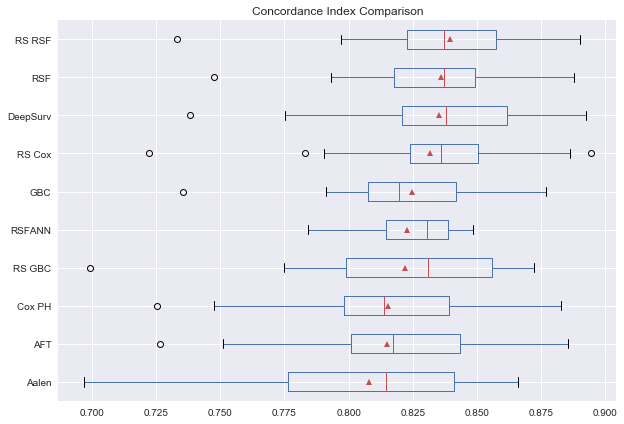

In [56]:
fig, ax = plt.subplots(figsize=(10,7))
df_csv.boxplot(ax=ax, column = [ 'Aalen', 'AFT', 'Cox PH', 'RS GBC', 'RSFANN', 'GBC', 'RS Cox', 'DeepSurv' , 'RSF', 'RS RSF'],patch_artist = False, vert = False, showmeans = True)
plt.savefig('Scores.png', format='png', dpi=100)
plt.title('Concordance Index Comparison')
plt.show()